# Explore coregistration methods

In [1]:
import subprocess
import os
import xdem
import geoutils as gu

Stable reference elevations loaded from file.


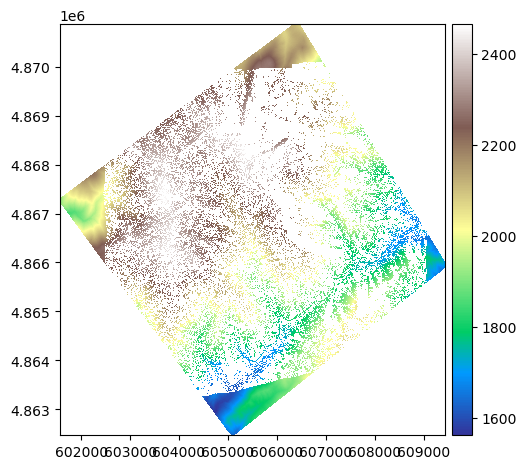

In [3]:
site_name = 'MCS'
date = '20240420'
data_dir = '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites'
asp_dir = '/Users/raineyaberle/Research/PhD/SnowDEMs/StereoPipeline-3.5.0-alpha-2024-10-05-x86_64-OSX/bin/'
refdem_fn = os.path.join(data_dir, site_name, 'refdem', 'MCS_REFDEM_WGS84.tif')
ss_mask_fn = os.path.join(data_dir, site_name, date, 'land_cover_masks', 'stable_surfaces_mask.tif')
dem_fn = os.path.join(data_dir, site_name, date, f'coregAll_ba-u5m_{site_name}_{date}_DEM.tif')

# Mask reference DEM to stable surfaces
refdem_stable_fn = os.path.join(data_dir, site_name, date, 'land_cover_masks', os.path.basename(refdem_fn).replace('.tif', '_stable.tif'))
if not os.path.exists(refdem_stable_fn):
    refdem = xdem.DEM(refdem_fn, load_data=True)
    ss_mask = gu.Raster(ss_mask_fn, load_data=True).reproject(refdem)
    ss_mask = (ss_mask==1)
    
    refdem_stable = refdem.copy()
    refdem_stable.set_mask(~ss_mask)

    refdem_stable.save(refdem_stable_fn)
    print('Stable reference elevations saved to file:', refdem_stable_fn)
    
else:
    refdem_stable = xdem.DEM(refdem_stable_fn)
    print('Stable reference elevations loaded from file.')

refdem_stable.plot(cmap='terrain')


In [ ]:
# Set up coregistration
out_prefix = os.path.join(os.path.dirname(refdem_stable_fn), 'run')
cmd = [os.path.join(asp_dir, 'pc_align'),
       '--max-displacement', '40',
       '--save-transformed-source-points',
       '-o', out_prefix,
       refdem_stable_fn, dem_fn]
out = subprocess.run(cmd, capture_output=True, shell=False)
print(out)

In [ ]:
cmd = [os.path.join(asp_dir, 'point2dem'),
       out_prefix + '-trans_source.tif']
out = subprocess.run(cmd, capture_output=True, shell=False)
print(out)

In [ ]:
import numpy as np

dem_coreg_fn = os.path.join(out_prefix + '-trans_source-DEM.tif')

dem = xdem.DEM(dem_coreg_fn)
refdem = xdem.DEM(refdem_fn).reproject(dem)
ss_mask = gu.Raster(ss_mask_fn).reproject(dem)
ss_mask = (ss_mask==1)
gcp_fn = "/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/ITD_Functional_Class/ITD_HWY_21.shp"
gcp = gu.Vector(gcp_fn)
gcp = gu.Vector(gcp_fn).reproject(dem)
gcp = gcp.create_mask(dem)

shift = xdem.coreg.VerticalShift().fit(refdem, dem, gcp)
zshift = shift.meta['outputs']['affine']['shift_z'] + 0
print(f"Vertical shift = {np.round(float(zshift),2)} m")
dem_zshift = dem + zshift   
ddem = dem_zshift - refdem

ddem_ss = ddem[ss_mask]
print(np.ma.median(ddem_ss), xdem.spatialstats.nmad(ddem_ss))

In [ ]:
ddem.plot(cmap='coolwarm_r', vmin=-5, vmax=5)


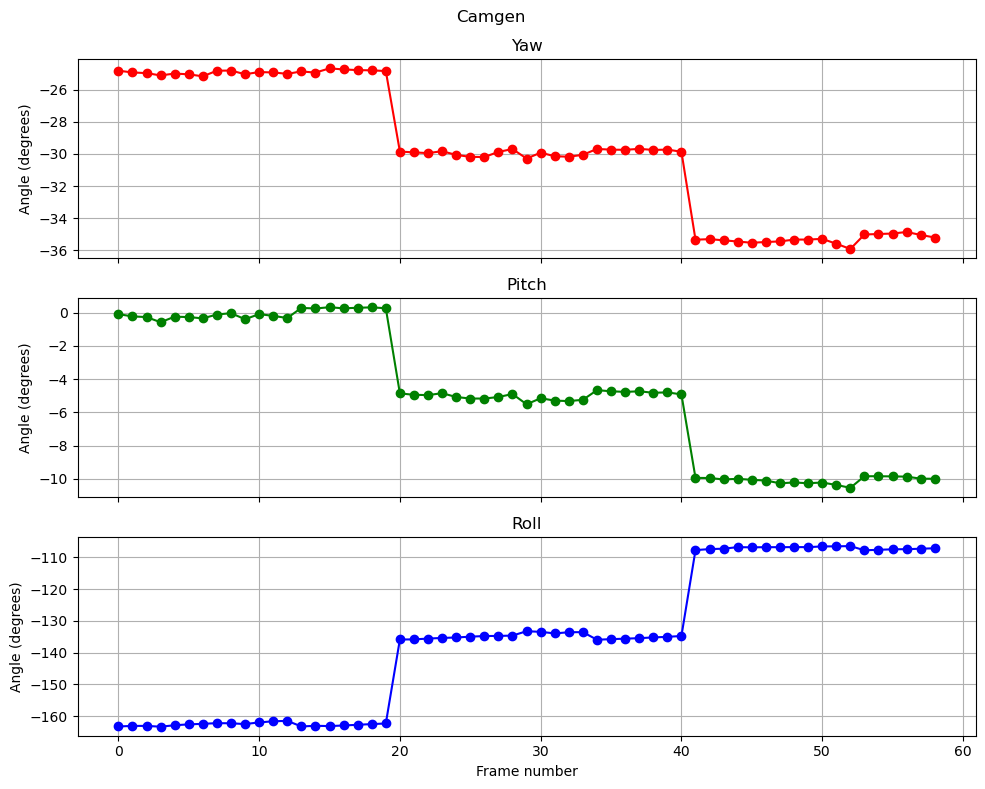

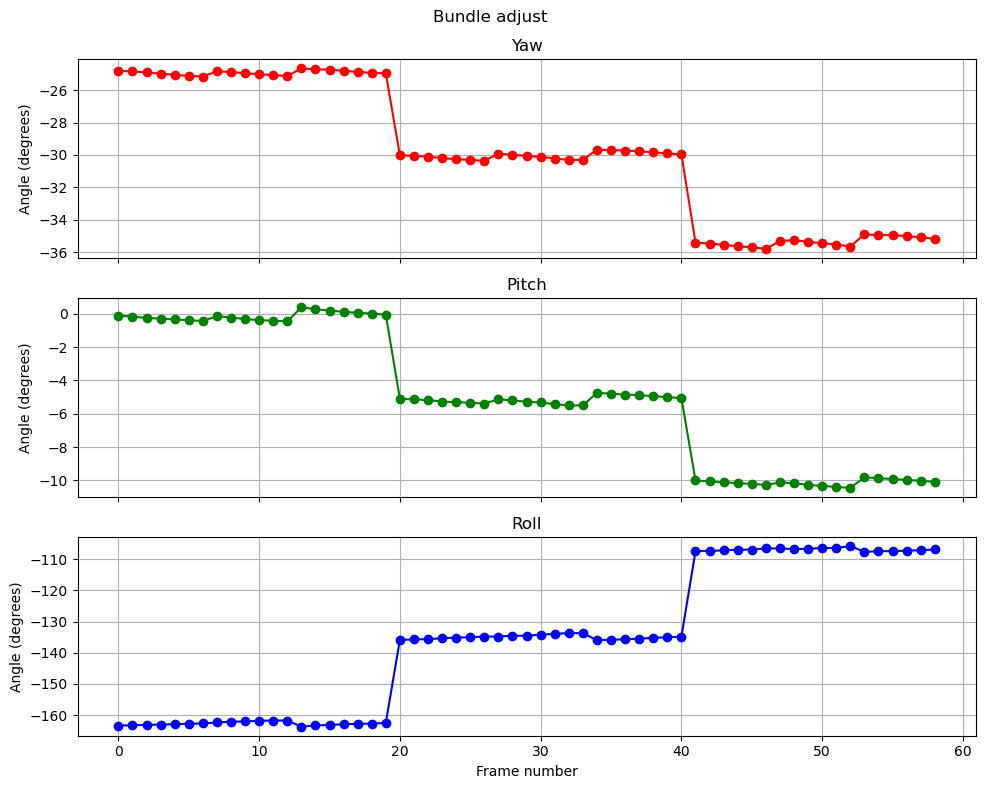

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob

def parse_tsai_R(tsai_path):
    """Extracts the rotation matrix from a TSAI camera model file."""
    R = None
    with open(tsai_path, 'r') as f:
        for line in f:
            if line.startswith('R = '):
                # Extract rotation matrix elements
                values_list = line.split('R = ')[1:]
                values_list = values_list[0].replace('\n','')
                values_split = values_list.split(' ')
                values = [float(x) for x in values_split]
                R = np.array(values).reshape(3, 3)
                break  
    return R

def rotation_matrix_to_euler(R):
    """Extracts yaw, pitch, and roll from a 3x3 rotation matrix."""
    yaw = np.arctan2(R[1, 0], R[0, 0])      # Rotation around Z-axis
    pitch = -np.arcsin(R[2, 0])             # Rotation around Y-axis
    roll = np.arctan2(R[2, 1], R[2, 2])     # Rotation around X-axis

    # Convert from radians to degrees
    return np.degrees(yaw), np.degrees(pitch), np.degrees(roll)

def plot_yaw_pitch_roll(tsai_files, suptitle=None):
    yaw_list, pitch_list, roll_list = [], [], []
    for tsai_file in tsai_files:
        R = parse_tsai_R(tsai_file)
        if R is not None:
            yaw, pitch, roll = rotation_matrix_to_euler(R)
            yaw_list.append(yaw)
            pitch_list.append(pitch)
            roll_list.append(roll)

    # Plot results
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    axes[0].plot(np.arange(len(yaw_list)), yaw_list, marker='o', linestyle='-', color='r')
    axes[0].set_title('Yaw')
    axes[1].plot(np.arange(len(pitch_list)), pitch_list, marker='o', linestyle='-', color='g')
    axes[1].set_title('Pitch')
    axes[2].plot(np.arange(len(roll_list)), roll_list, marker='o', linestyle='-', color='b')
    axes[2].set_title('Roll')
    for ax in axes:
        ax.grid(True)
        ax.set_ylabel("Angle (degrees)")
    axes[2].set_xlabel("Frame number")
    if suptitle:
        fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()
    
# Camgen cameras
tsai_files = sorted(glob.glob(os.path.join(data_dir, 'Banner', '20240419-2', 'testing', 'camgen', '*.tsai')))
plot_yaw_pitch_roll(tsai_files, suptitle='Camgen')

# Bundle adjusted cameras
tsai_files = sorted(glob.glob(os.path.join(data_dir, 'Banner', '20240419-2', 'testing', 'ba', '*.tsai')))
plot_yaw_pitch_roll(tsai_files, suptitle='Bundle adjust')


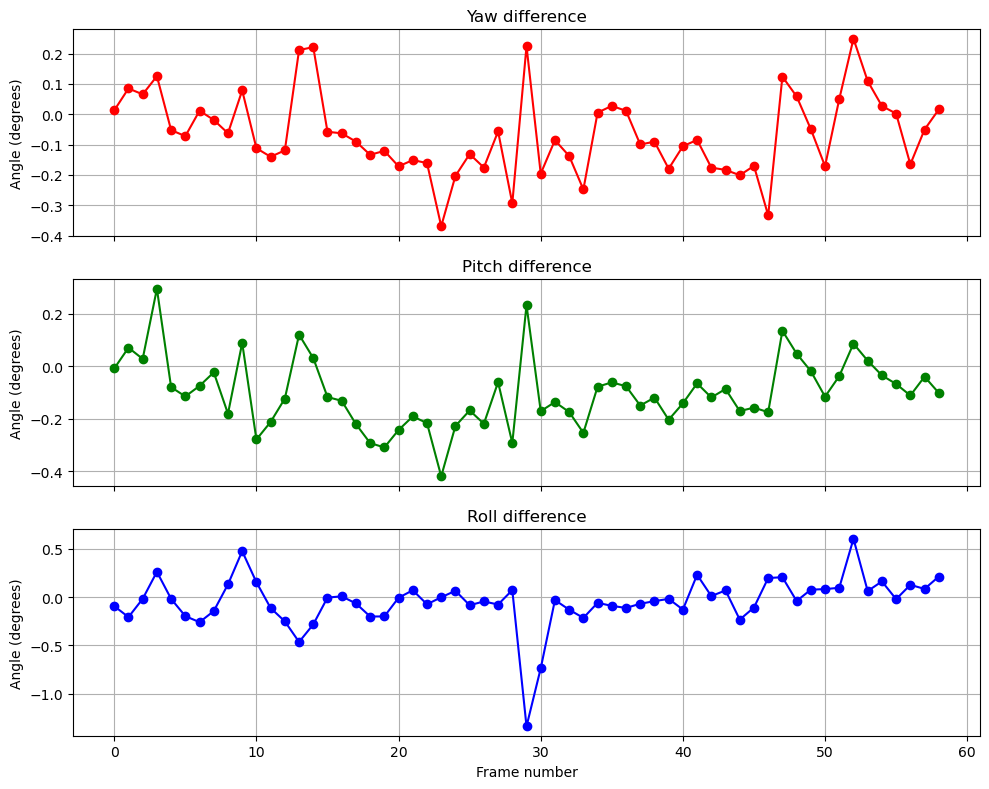

In [6]:
tsai_camgen_files = sorted(glob.glob(os.path.join(data_dir, 'Banner', '20240419-2', 'testing', 'camgen', '*.tsai')))
tsai_ba_files = sorted(glob.glob(os.path.join(data_dir, 'Banner', '20240419-2', 'testing', 'ba', '*.tsai')))

yaw_diff = np.zeros(len(tsai_camgen_files))
pitch_diff = np.zeros(len(tsai_camgen_files))
roll_diff = np.zeros(len(tsai_camgen_files))
for i, camgen_file in enumerate(tsai_camgen_files):
    camgen_R = parse_tsai_R(camgen_file)
    camgen_yaw, camgen_pitch, camgen_roll = rotation_matrix_to_euler(camgen_R)
    
    ba_file = [x for x in tsai_ba_files if os.path.basename(camgen_file).split('_rpc')[0] in os.path.basename(x)][0]
    ba_R = parse_tsai_R(ba_file)
    ba_yaw, ba_pitch, ba_roll = rotation_matrix_to_euler(ba_R)

    yaw_diff[i] = ba_yaw - camgen_yaw
    pitch_diff[i] = ba_pitch - camgen_pitch
    roll_diff[i] = ba_roll - camgen_roll
    
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axes[0].plot(np.arange(len(tsai_camgen_files)), yaw_diff, marker='o', linestyle='-', color='r')
axes[0].set_title('Yaw difference')
axes[1].plot(np.arange(len(tsai_camgen_files)), pitch_diff, marker='o', linestyle='-', color='g')
axes[1].set_title('Pitch difference')
axes[2].plot(np.arange(len(tsai_camgen_files)), roll_diff, marker='o', linestyle='-', color='b')
axes[2].set_title('Roll difference')
for ax in axes:
    ax.grid(True)
    ax.set_ylabel("Angle (degrees)")
axes[2].set_xlabel("Frame number")
plt.tight_layout()
plt.show()